In [1]:
# Libraries
# !pip install nilearn

import nibabel as nib
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.models import Model
from keras.layers import Input, Dropout, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import MeanIoU



In [2]:
# Paths and dataset
TRAIN_DATASET_PATH = '../input/siss2015small/SISS2015_Training/'
PNG_PATH = '../input_png/'
PNG_TRAIN_DATASET_PATH = '../input_png/SISS2015_Training/'
train_directories = [f.path+'/' for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
train_ids = train_directories.copy()
train_ids.sort()

# train_test_ids, val_ids = train_test_split(train_ids, test_size=0.2, shuffle=False)
# train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15, shuffle=False)

VOLUME_SLICES = 153
VOLUME_START_AT = 0
IMG_SIZE=192



In [3]:
try:
    os.makedirs(PNG_TRAIN_DATASET_PATH, exist_ok=True)
except FileExistsError as e:
    print("Folder already exists!")

try:
    for i in range(1, 29):
        os.mkdir(PNG_TRAIN_DATASET_PATH + "{}/".format(str(i)))
except FileExistsError as e:
    print("Folder already exists!")



In [4]:
print("TOTAL TRAINING SAMPLES: ", )
print("SAMPLE 1: ", train_ids[0])

print("CURRENT WORKING DIRECTORY: ", os.getcwd())
print("CURRENT WORKING DIRECTORY ITEMS: ", os.listdir('../'))
print("PNG DATASET DIRECTORY ITEMS: ", os.listdir(PNG_TRAIN_DATASET_PATH))



TOTAL TRAINING SAMPLES: 
SAMPLE 1:  ../input/siss2015small/SISS2015_Training/1/
CURRENT WORKING DIRECTORY:  /kaggle/working
CURRENT WORKING DIRECTORY ITEMS:  ['src', 'lib', 'input_png', 'input', 'working']
PNG DATASET DIRECTORY ITEMS:  ['27', '22', '5', '23', '11', '6', '12', '24', '17', '20', '28', '18', '21', '4', '16', '10', '19', '26', '1', '25', '15', '9', '7', '3', '2', '8', '13', '14']


Path:  ../input_png/SISS2015_Training/1/
File Name:  1_1_slice_2.png
File Name with Path:  ../input_png/SISS2015_Training/1/1_1_slice_2.png
Saved all PNGs for sample  1
Total PNGs for sample 1:  770
Saved all PNGs for sample  2
Saved all PNGs for sample  3
Saved all PNGs for sample  4
Saved all PNGs for sample  5
Saved all PNGs for sample  6
Saved all PNGs for sample  7
Saved all PNGs for sample  8
Saved all PNGs for sample  9
Saved all PNGs for sample  10
Saved all PNGs for sample  11
Saved all PNGs for sample  12
Saved all PNGs for sample  13
Saved all PNGs for sample  14
Saved all PNGs for sample  15
Saved all PNGs for sample  16
Saved all PNGs for sample  17
Saved all PNGs for sample  18
Saved all PNGs for sample  19
Saved all PNGs for sample  20
Saved all PNGs for sample  21
Saved all PNGs for sample  22
Saved all PNGs for sample  23
Saved all PNGs for sample  24
Saved all PNGs for sample  25
Saved all PNGs for sample  26
Saved all PNGs for sample  27
Saved all PNGs for sample  28

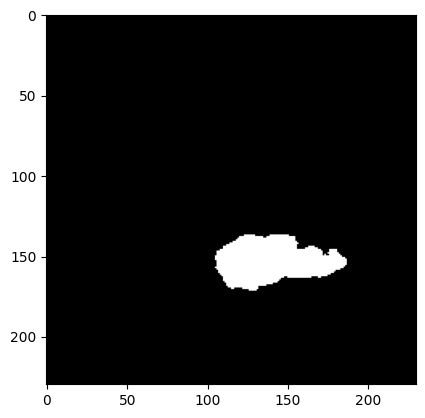

In [5]:
mod_dict = {
    1: ".MR_DWI.", 
    2: ".MR_Flair.", 
    3: ".MR_T1.", 
    4: ".MR_T2.", 
    5: ".OT." # MASK OUTPUT
}
TOTAL_TRAINING_SAMPLES = len(train_ids) #28
nii_counter = 70613

def nii_to_png():
    global nii_counter
    global TOTAL_TRAINING_SAMPLES
    for i in range(1, TOTAL_TRAINING_SAMPLES + 1):
        if i == 15:
            nii_counter = 70707
        if i == 16:
            nii_counter = 70717
        if i == 19:
            nii_counter = 70747
        if i == 20:
            nii_counter = 70761
        for j in range(1, len(mod_dict) + 1):
            if i == 16 and j == 3:
                nii_counter = 70725
            if i == 19 and j == 2:
                nii_counter = 70750
            if i == 19 and j == 3:
                nii_counter = 70753
            if i == 19 and j == 5:
                nii_counter = 70758
            if i == 20 and j == 2:
                nii_counter = 70768
            sample_path = "{}/VSD.Brain.XX.O{}{}".format(str(i), mod_dict[j], str(nii_counter))
            file_name = "/VSD.Brain.XX.O{}".format(mod_dict[j]) + str(nii_counter) + ".nii"
            data_path = os.path.join(TRAIN_DATASET_PATH + sample_path + file_name)
#             print(i, data_path)
            if j != 4:
                nii_counter += 1
            else:
                nii_counter += 2

            if os.path.exists(data_path):
                mri_image = nib.load(data_path).get_fdata()
#                 print("Total Slices: ", i, mri_image.shape[-1])
                for curr_slice in range(mri_image.shape[-1]): # Slice Values (153, 154)
                    slice_data = mri_image[..., curr_slice]
                    if i == 14 and curr_slice == 66: # Test Sample
                        plt.imshow(slice_data, cmap='gray')
                    sample_path = "{}/VSD.Brain.XX.O{}{}".format(str(i), mod_dict[j], str(nii_counter - 1 if j != 4 else 2))
                    file_name = "{}_{}_slice_{}.png".format(i, j, curr_slice + 1) # mod_dict[j][1:-1]
#                     png_path = os.path.join(PNG_TRAIN_DATASET_PATH + sample_path)
                    png_path = "{}{}/".format(PNG_TRAIN_DATASET_PATH, i)
                    if i == 1 and j == 1 and curr_slice == 1: # Test Sample
                        print("Path: ", png_path)
                        print("File Name: ", file_name)
                        print("File Name with Path: ", png_path + file_name)
                    try:
                        plt.imsave(png_path + file_name, slice_data, cmap='gray')
                        pass
                    except Exception as e:
                        print("Error: ", e)
            else:
                print(f"File not found: {data_path}")
        print("Saved all PNGs for sample ", i)
        if i == 1 or i == 28:
            print("Total PNGs for sample {}: ".format(i), len(os.listdir(png_path)))
        pass
#         print(i, end = " ")
        
        
nii_to_png()

